In [43]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [44]:
def plot_series(time,series,format='-',start=0,end=None,label=None):
  plt.plot(time[start:end],series[start:end],format,label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [45]:
def trend(time,slope=0):
  return slope * time

In [46]:
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3* season_time))

In [47]:
def seasonality(time,period,aplitude=1,phase=0):
  season_time = ((time + phase)% period) / period
  return aplitude * seasonal_pattern(season_time)

In [48]:
def white_noise(time,noise_level=1,seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

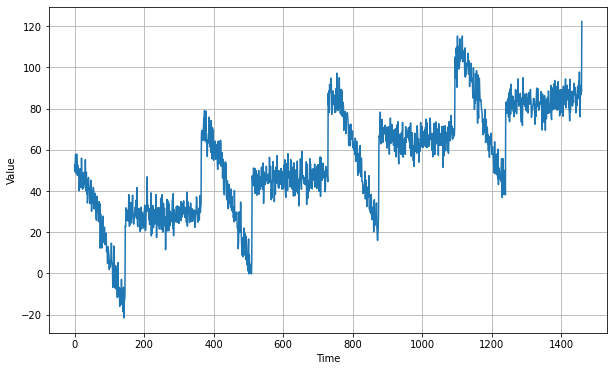

In [49]:
# Time and Seasonality
time = np.arange(4 * 365+1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time,slope) + seasonality(time,period=365,aplitude=amplitude)

noise_level = 5
noise = white_noise(time,noise_level,seed=42)

series += noise

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

# Graph looks good, lets try to forecast it

In [50]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


## Naive forecasting

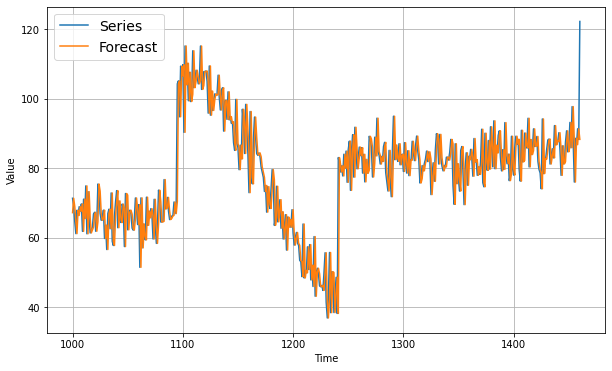

In [51]:
naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid, label="Series")

plot_series(time_valid, naive_forecast, label="Forecast")
plt.show()

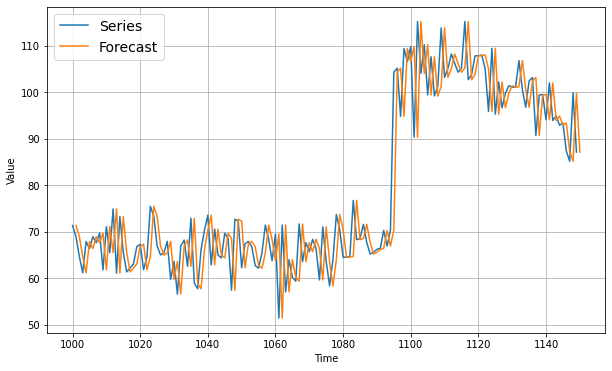

In [52]:
plt.figure(figsize=(10,6))

plot_series(time_valid,x_valid,start=0,end=150,label='Series')

plot_series(time_valid,naive_forecast,start=1,end=151,label='Forecast')
plt.show()

In [53]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)

mae = abs_errors.mean()
mae

5.9379085153216735

# Moving Average

In [54]:
def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [55]:
def moving_average_forecast(series, window_size):
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

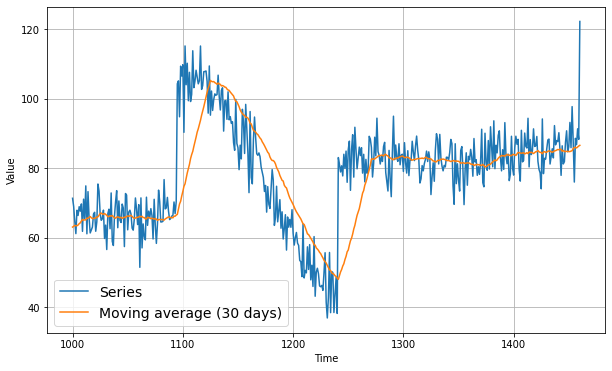

In [56]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [57]:
keras.metrics.mean_absolute_error(x_valid,moving_avg).numpy()

7.1424185706207854

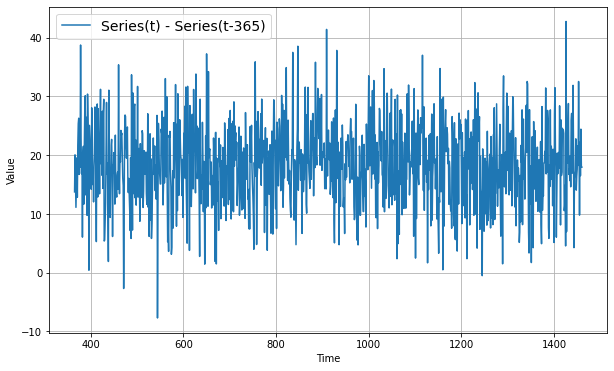

In [58]:
diff_series = (series[365:]) - series[:-365]
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time,diff_series,label='Series(t) - Series(t-365)')
plt.show()

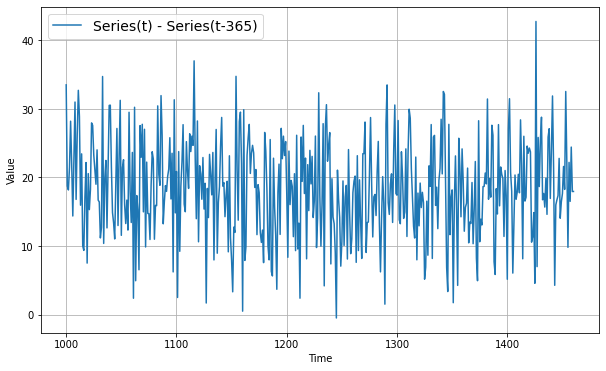

In [59]:
plt.figure(figsize=(10,6))
plot_series(time_valid,diff_series[split_time - 365:] ,label='Series(t) - Series(t-365)')

plt.show()

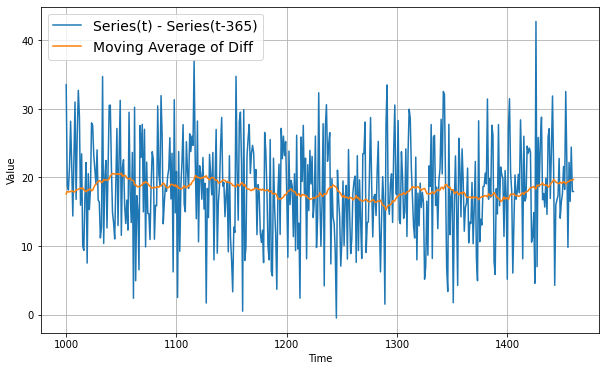

In [60]:
diff_moving_avg_plus_past = moving_average_forecast(diff_series,50)[split_time - 365 - 50:]

plt.figure(figsize=(10,6))

plot_series(time_valid,diff_series[split_time - 365:],label='Series(t) - Series(t-365)')
plot_series(time_valid,diff_moving_avg_plus_past,label='Moving Average of Diff')
plt.show()

In [61]:
keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_past).numpy()

60.201029510326244

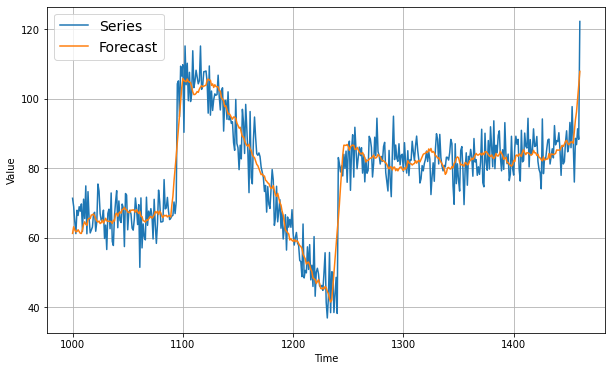

In [62]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359],11) + diff_moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid,label='Series')
plot_series(time_valid,diff_moving_avg_plus_smooth_past,label='Forecast')
plt.show()

In [63]:
keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_smooth_past).numpy()

4.566859958970772